# Machine Learning Project

## Binary classification based on 3 layers neural network (2)

#### First layer

$Z^{[1]} = W^{[1]} X + b^{[1]}$ : $X$ denotes the input data

$A^{[1]} = g^{[1]}(Z^{[1]})$ : $g^{[1]}$ is the activation function at the first layer

#### Second layer

$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$

$A^{[2]} = g^{[2]}(Z^{[2]})$ : $g^{[2]}$ is the activation function at the second layer

#### Third layer

$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$

$A^{[3]} = g^{[3]}(Z^{[3]})$ : $g^{[3]}$ is the activation function at the third (output) layer

### Activation Function

- Sigmoid

    $g(z) = \frac{1}{1 + \exp^{-z}}$

- tanh

    $g(z) = \frac{\exp^{z} - \exp^{-z}}{\exp^{z} + \exp^{-z}}$

- ReLU

    $g(z) = \max(0, z)$

- Leaky ReLU

    $g(z) = \max(\alpha z, z), \quad \alpha \in \mathbb{R}^+$

### Neural Network Architecture

- The sizes of the hidden layers and the output layer should be determined with respect to the validation accuracy obtained by the network architecture with all the activation functions being sigmoid functions. ($g^{[1]} = g^{[2]} = g^{[3]} =$ Sigmoid)
- Apply different activation functions at all the layers except the output layer that should be Sigmoid function
- Apply different activation functions at different layers except the output layer that should be Sigmoid function

### Dataset

- The dataset consists of human images and horse images for the training and the validation
- The classifier should be trained using the training set
- The classifier should be tested using the validation set
- Vectorize an input image matrix into a column vector

### Implementation

- Write codes in python programming
- Use jupyter notebook for the programming environment
- You can use any libarary
- You have to write your own functions for the followings:
    - compute the forward propagation
    - compute the backward propagation
    - compute the loss
    - compute the accuracy
    - compute the gradient of the model parameters with respect to the loss
    - update the model parameters
    - plot the results

### Optimization

- Apply the gradient descent algorithm with an appropriate learning rate
- Apply the number of iterations that lead to the convergence of the algorith
- Use the vectorization scheme in the computation of gradients and the update of the model parameters

### [ Implementation ]

#### (1) Libraries and Global variables

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import math
import os

# Global Variables
train_data_path = './horse-or-human/train'
validation_data_path = './horse-or-human/validation'

layer_dims = [10000,50,10,1]    # number of units(Neurons) in each layer
learning_rate = 0.02            # step size per each epoch (iteration)
threshold = 0.1                 # minimum of cost
max_epoch = 2500                # maximum number of epoch (iteration)

#### (2) Generate Input matrix X and Output vector Y from training and validation datasets

In [4]:
def initialize_inputs(image_path) :
    transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),])
    # the code transforms.Grayscale() is for changing the size [3,100,100] to [1, 100, 100]
    # (notice : [channel, height, width] )
    image_set = torchvision.datasets.ImageFolder(root=image_path, transform=transform)
    loader = torch.utils.data.DataLoader(image_set, batch_size=1, shuffle=False, num_workers=1)  

    for i,data in enumerate(loader) :
        image, label = data
        image = image.view(10000,1)
        label = label.view(1,1).type(torch.FloatTensor)
        
        if i == 0 :
            t_images = image
            t_labels = label
        else :
            t_images = torch.cat((t_images,image),dim = 1)
            t_labels = torch.cat((t_labels,label),dim = 1)
        
        images = t_images.numpy()
        labels = t_labels.numpy()
    
    return images, labels

#### (3) Activation Functions

In [31]:
def Sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def Sigmoid_backward(dA, Z):
    t_A = 1/(1+np.exp(-Z))
    dZ = dA * t_A * (1-t_A)
    return dZ

def ReLU(Z):
    A = np.maximum(0,Z)
    return A

def ReLU_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0    
    return dZ

def Leaky_ReLU(Z) :
    A = np.maximum(0.01*Z, Z)
    return A

def Leaky_ReLU_backward(dA,Z) :
    dZ = np.array(dA, copy=True)
    dZ[Z < 0] *= 0.01
    return dZ
    
def Tanh(Z) :
    A = np.tanh(Z)
    return A

def Tanh_backward(dA, Z) :
    t_A = np.tanh(Z)
    dZ = dA * (1 - np.square(t_A))
    return dZ

#### (4) Cost and Parameter initialization / update Functions

In [20]:
def initalize_parameters(n) :
    parameters = dict()
    
    # Initalize W[i] and b[i] for i in [1,L-1]
    for l in range(1,len(n)) :
        parameters['W'+str(l)] = np.random.randn(n[l],n[l-1]) / np.sqrt(n[l-1])
        parameters['b'+str(l)] = np.zeros((n[l],1))
        
    return parameters

def update_parameters(parameters,gradients,learning_rate) :
    L = len(parameters) // 2
    
    # Update W[i] and b[i] for i in [1,L]
    for l in range(1,L+1) :
        dW, db = gradients['dW'+str(l)], gradients['db'+str(l)]
        parameters['W'+str(l)] -= learning_rate * dW
        parameters['b'+str(l)] -= learning_rate * db

    return parameters

def cost_computation(AL, Y) :
    m = Y.shape[1]
    
    cost = (-np.dot(Y,np.log(AL).T) - np.dot(1-Y,np.log(1-AL).T)) / m
    cost = np.squeeze(cost)
    return cost

#### (5) Forward Propagation

In [21]:
def forward_Z_computation(A_prev,W,b) :
    Z = np.dot(W,A_prev) + b
    return Z

def forward_A_computation(A_prev,W,b,activation) :
    assert activation in ['sigmoid','relu','tanh','leaky_relu']
    
    Z = forward_Z_computation(A_prev,W,b)
    if activation == 'sigmoid' :
        A = Sigmoid(Z)
    elif activation == 'relu' :
        A = ReLU(Z)
    elif activation == 'tanh' :
        A = Tanh(Z)
    else :
        A = Leaky_ReLU(Z)
    
    cache = ((A_prev,W,b),Z)
    return A, cache

def forward_propagation(X,parameters,activations) :
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1,L+1) :
        A_prev, W, b = A, parameters['W'+str(l)], parameters['b'+str(l)]
        A,cache = forward_A_computation(A_prev,W,b,activations[l-1])
        caches.append(cache)    
    AL = A
    
    return AL, caches

#### (6) Backward Propagation

In [22]:
def backward_params_dev_computation(dZ, cache) :
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ,a_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def backward_params_dev_computation(dA,cache,activation) :
    assert activation in ['sigmoid','relu','tanh','leaky_relu']
    (A_prev,W,b),Z = cache
    m = A_prev.shape[1]

    if activation == 'sigmoid' :
        dZ = Sigmoid_backward(dA,Z)
    elif activation == 'relu' :
        dZ = ReLU_backward(dA,Z)
    elif activation == 'tanh' :
        dZ = Tanh_backward(dA,Z)
    else :
        dZ = Leaky_ReLU_backward(dA,Z)
    
    dW = np.dot(dZ,A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def backward_propagation(AL, Y, caches,activations) :
    gradients = dict()
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y,AL) - np.divide(1-Y,1-AL))
    cache = caches[L-1]
    dA_prev, dW, db = backward_params_dev_computation(dAL,cache,activations[L-1])
    gradients['dA'+str(L)] = dA_prev
    gradients['dW'+str(L)] = dW
    gradients['db'+str(L)] = db
    
    for l in reversed(range(1,L)) :
        dA = gradients['dA' + str(l+1)]
        dA_prev, dW, db = backward_params_dev_computation(dA,caches[l-1],activations[l-1])
        gradients['dA'+str(l)] = dA_prev
        gradients['dW'+str(l)] = dW
        gradients['db'+str(l)] = db
        
    return gradients

#### (7) Predictions

In [9]:
def predict(AL,Y) :
    correct = np.zeros(Y.shape)
    m = AL.shape[1]

    prediction = AL > 0.5
    correct = prediction == Y
    
    accuracy = np.sum(correct) / m
    return accuracy

#### (8) 3-layer Neural Network

In [43]:
def NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch) :

    np.random.seed(1)
    costs, t_costs = [],[]
    accuracy, t_accuracy = [],[]
    parameters = initalize_parameters(n)
    
    for epoch in range(max_epoch) :
        AL, caches = forward_propagation(X, parameters, activations)
        t_AL, _t = forward_propagation(t_X, parameters, activations)
        
        cost = cost_computation(AL, Y)
        t_cost = cost_computation(t_AL, t_Y)
        
        gradients = backward_propagation(AL, Y, caches,activations)
        
        parameters = update_parameters(parameters,gradients,learning_rate)
        
        costs.append(cost)
        t_costs.append(t_cost)
        
        accuracy.append(predict(AL,Y))
        t_accuracy.append(predict(t_AL,t_Y))
        
#        if  epoch % 10 == 0:
#            print ("Cost after iteration %i: %f" %(epoch, cost))
        if cost < threshold :
            break
            
    return costs, accuracy, t_costs, t_accuracy

#### (9) Plot Loss and Accuracy Graphs

In [11]:
def plotResult(costs,accuracy,title) :
    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(121)
    plt.title('Costs', fontsize = 15, color = 'black')
    plt.plot(np.squeeze(costs))
    plt.subplot(122)
    plt.title('Accuracy', fontsize = 15, color = 'black')
    plt.plot(np.squeeze(accuracy))
    plt.suptitle(title, fontsize = 20, color = 'black',position=(0.5, 1.0+0.05))
    plt.show()

### Output



- Plot the training loss at every iteration (x-axis: iteration, y-axis: loss)
- Plot the validation loss at every iteration (x-axis: iteration, y-axis: loss)
- Plot the training accuracy at every iteration (x-axis: iteration, y-axis: accuracy)
- Plot the validation accuracy at every iteration (x-axis: iteration, y-axis: accuracy)
- Present the table for the final accuracy and loss with training and validation datasets with your best neural network architecture as below:

In [14]:
X,Y = initialize_inputs(train_data_path)
t_X, t_Y = initialize_inputs(validation_data_path)

n = [10000,50,10,1]

##### (1) $g^{[1]}, g^{[2]}, g^{[3]}$ are Sigmoid (from the previous assignment)

- Learning curves
- Loss and Accuracy table

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |  0.48654   |   80.82 %  |
| validation |  0.39640   |   87.50 %  |

In [61]:
activations = ['sigmoid','sigmoid','sigmoid']
learning_rate = 0.01
thres_hold = 0.01
max_epoch = 3000

costs, accuracy, t_costs, t_accuracy = NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch)

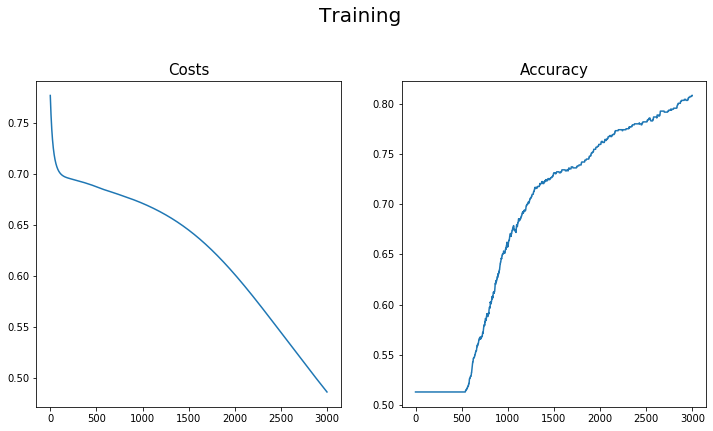

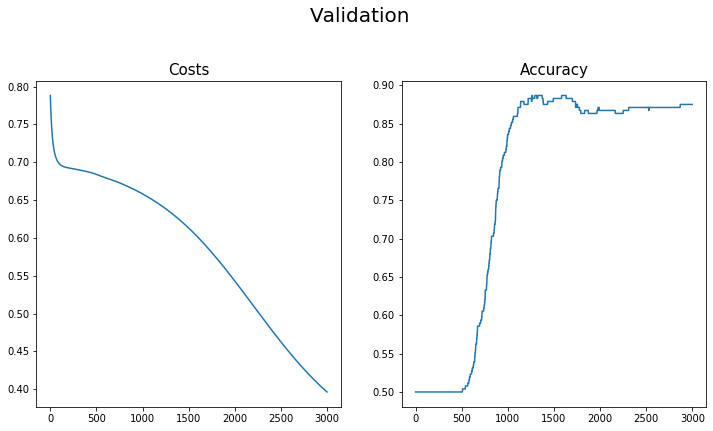

In [62]:
plotResult(costs, accuracy,'Training')
plotResult(t_costs, t_accuracy, 'Validation')

In [63]:
print("Training Loss       : %.5f" % costs[-1])
print("Training Accuracy   : %.2f %%" % (accuracy[-1] * 100))
print("Validation Loss     : %.5f" % t_costs[-1])
print("Validation Accuracy : %.2f %%" % (t_accuracy[-1] * 100))

Training Loss       : 0.48654
Training Accuracy   : 80.82 %
Validation Loss     : 0.39640
Validation Accuracy : 87.50 %


##### (2) $g^{[1]}, g^{[2]}$ are tanh and $g^{[3]}$ is Sigmoid

- Learning curves
- Loss and Accuracy table

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |  0.22375   |   95.33 %  |
| validation |  0.37413   |   81.25 %  |

In [44]:
activations = ['tanh','tanh','sigmoid']
learning_rate = 0.002
thres_hold = 0.01
max_epoch = 2500

costs, accuracy, t_costs, t_accuracy = NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch)

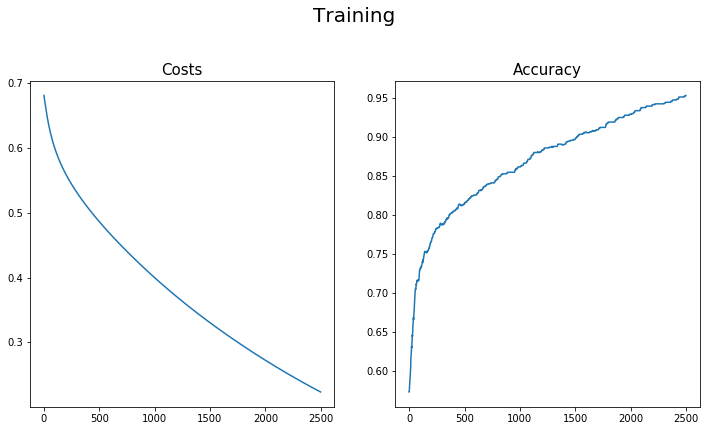

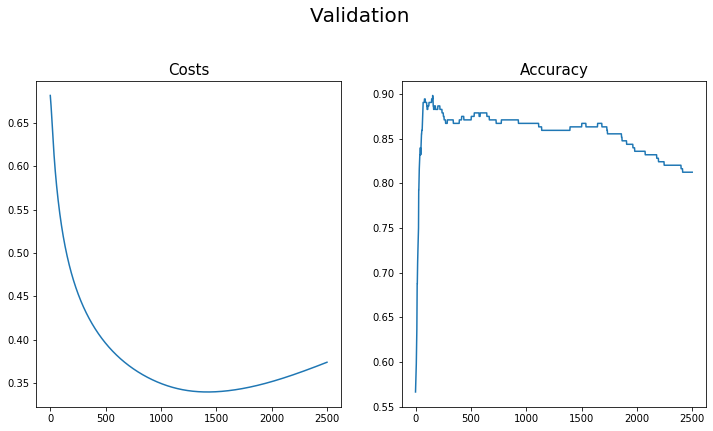

In [45]:
plotResult(costs, accuracy,'Training')
plotResult(t_costs, t_accuracy, 'Validation')

In [46]:
print("Training Loss       : %.5f" % costs[-1])
print("Training Accuracy   : %.2f %%" % (accuracy[-1] * 100))
print("Validation Loss     : %.5f" % t_costs[-1])
print("Validation Accuracy : %.2f %%" % (t_accuracy[-1] * 100))

Training Loss       : 0.22375
Training Accuracy   : 95.33 %
Validation Loss     : 0.37413
Validation Accuracy : 81.25 %


##### (3) $g^{[1]}, g^{[2]}$ are ReLU and $g^{[3]}$ is Sigmoid

- Learning curves
- Loss and Accuracy table 

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |  0.18629   |   95.33%   |
| validation |  0.40157   |   80.86%   |

In [45]:
activations = ['relu','relu','sigmoid']
learning_rate = 0.002
thres_hold = 0.01
max_epoch = 2500

costs, accuracy, t_costs, t_accuracy = NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch)

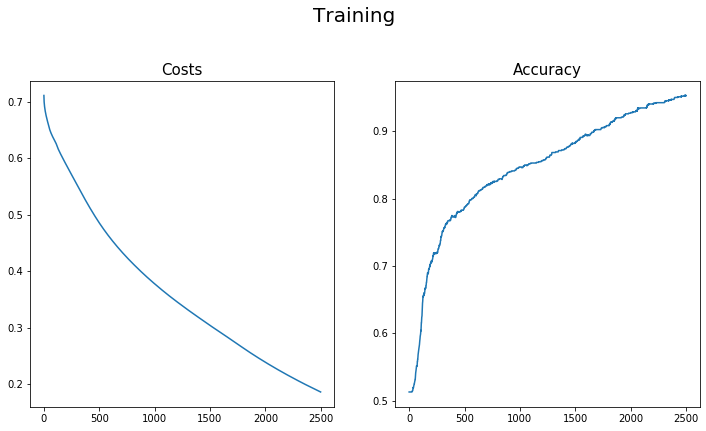

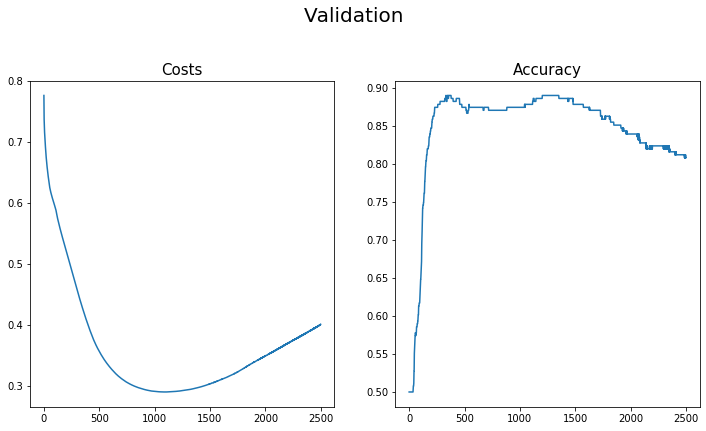

In [46]:
plotResult(costs, accuracy,'Training')
plotResult(t_costs, t_accuracy, 'Validation')

In [52]:
print("Training Loss       : %.5f" % costs[-1])
print("Training Accuracy   : %.2f %%" % (accuracy[-1] * 100))
print("Validation Loss     : %.5f" % t_costs[-1])
print("Validation Accuracy : %.2f %%" % (t_accuracy[-1] * 100))

Training Loss       : 0.18629
Training Accuracy   : 95.33 %
Validation Loss     : 0.40157
Validation Accuracy : 80.86 %


##### (4)  $g^{[1]}, g^{[2]}$ are Leaky ReLU ($\alpha = 0.1$) and $g^{[3]}$ is Sigmoid

- Learning curves
- Loss and Accuracy table

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |  0.18501   |   95.23 %  |
| validation |  0.40629   |   79.69 %  |

In [35]:
activations = ['leaky_relu','leaky_relu','sigmoid']
learning_rate = 0.002
thres_hold = 0.01
max_epoch = 2500

costs, accuracy, t_costs, t_accuracy = NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch)

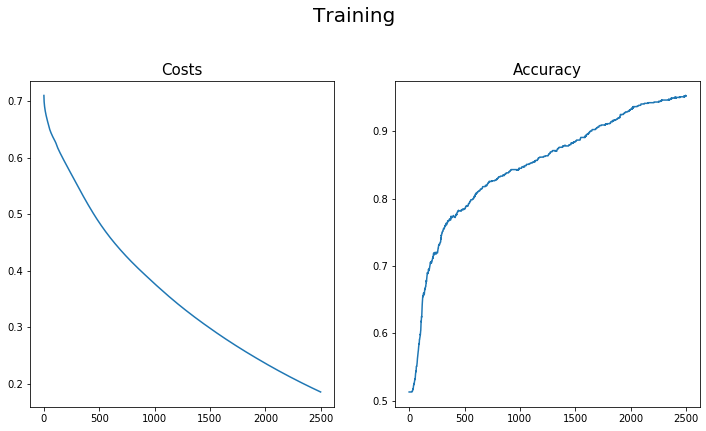

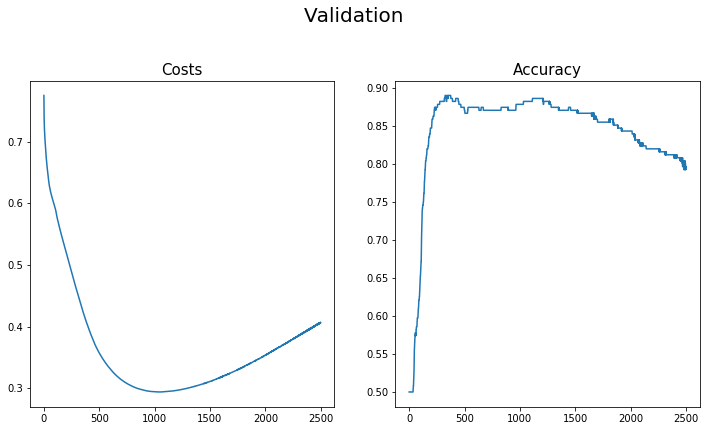

In [36]:
plotResult(costs, accuracy,'Training')
plotResult(t_costs, t_accuracy, 'Validation')

In [37]:
print("Training Loss       : %.5f" % costs[-1])
print("Training Accuracy   : %.2f %%" % (accuracy[-1] * 100))
print("Validation Loss     : %.5f" % t_costs[-1])
print("Validation Accuracy : %.2f %%" % (t_accuracy[-1] * 100))

Training Loss       : 0.18501
Training Accuracy   : 95.23 %
Validation Loss     : 0.40629
Validation Accuracy : 79.69 %
